# Assignment 4 - Generative Adversarial Networks
 
**Authors:**

1.   Liav Bachar 205888472
2.   Naor Kolet 205533060


# Imports

In [22]:
import pandas as pd
import numpy as np



# TensorFlow
import tensorflow as tf

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy


# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
# from sklearn.metrics import confusion_matrix, accuracy_score
# from sklearn.model_selection import StratifiedKFold
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import log_loss
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder
 
# Plots
# import seaborn as sns
import matplotlib.pyplot as plt

# Misc.
from scipy.io import arff
import os
import random
import joblib
import cv2
from glob import glob
from tqdm import tqdm_notebook as tqdm
import time

%matplotlib inline

In [7]:
SEED = 42
def set_seed():    
    random.seed(SEED)
    np.random.seed(SEED)
    tf.random.set_seed(SEED)

set_seed()

# Load Data

In [8]:
def load_arff_dataset(arff_path):
    data = arff.loadarff(arff_path)
    df = pd.DataFrame(data=data[0], columns=data[1].names())
    
    return df

In [9]:
# https://www.kaggle.com/uciml/pima-indians-diabetes-database
diab_df = load_arff_dataset(r'datasets/diabetes.arff')

In [10]:
diab_df

,preg,plas,pres,skin,insu,mass,pedi,age,class
0,6.0,148.0,72.0,35.0,0.0,33.6,0.627,50.0,b'tested_positive'
1,1.0,85.0,66.0,29.0,0.0,26.6,0.351,31.0,b'tested_negative'
2,8.0,183.0,64.0,0.0,0.0,23.3,0.672,32.0,b'tested_positive'
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0,b'tested_negative'
4,0.0,137.0,40.0,35.0,168.0,43.1,2.288,33.0,b'tested_positive'
...,...,...,...,...,...,...,...,...,...
763,10.0,101.0,76.0,48.0,180.0,32.9,0.171,63.0,b'tested_negative'
764,2.0,122.0,70.0,27.0,0.0,36.8,0.340,27.0,b'tested_negative'
765,5.0,121.0,72.0,23.0,112.0,26.2,0.245,30.0,b'tested_negative'
766,1.0,126.0,60.0,0.0,0.0,30.1,0.349,47.0,b'tested_positive'


In [11]:
# https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data)
cred_df = load_arff_dataset(r'datasets/german_credit.arff')

In [12]:
cred_df

,1,2,3,4,5,6,7,8,9,10,...,12,13,14,15,16,17,18,19,20,21
0,b'A11',6.0,b'A34',b'A43',1169.0,b'A65',b'A75',4.0,b'A93',b'A101',...,b'A121',67.0,b'A143',b'A152',2.0,b'A173',1.0,b'A192',b'A201',b'1'
1,b'A12',48.0,b'A32',b'A43',5951.0,b'A61',b'A73',2.0,b'A92',b'A101',...,b'A121',22.0,b'A143',b'A152',1.0,b'A173',1.0,b'A191',b'A201',b'2'
2,b'A14',12.0,b'A34',b'A46',2096.0,b'A61',b'A74',2.0,b'A93',b'A101',...,b'A121',49.0,b'A143',b'A152',1.0,b'A172',2.0,b'A191',b'A201',b'1'
3,b'A11',42.0,b'A32',b'A42',7882.0,b'A61',b'A74',2.0,b'A93',b'A103',...,b'A122',45.0,b'A143',b'A153',1.0,b'A173',2.0,b'A191',b'A201',b'1'
4,b'A11',24.0,b'A33',b'A40',4870.0,b'A61',b'A73',3.0,b'A93',b'A101',...,b'A124',53.0,b'A143',b'A153',2.0,b'A173',2.0,b'A191',b'A201',b'2'
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,b'A14',12.0,b'A32',b'A42',1736.0,b'A61',b'A74',3.0,b'A92',b'A101',...,b'A121',31.0,b'A143',b'A152',1.0,b'A172',1.0,b'A191',b'A201',b'1'
996,b'A11',30.0,b'A32',b'A41',3857.0,b'A61',b'A73',4.0,b'A91',b'A101',...,b'A122',40.0,b'A143',b'A152',1.0,b'A174',1.0,b'A192',b'A201',b'1'
997,b'A14',12.0,b'A32',b'A43',804.0,b'A61',b'A75',4.0,b'A93',b'A101',...,b'A123',38.0,b'A143',b'A152',1.0,b'A173',1.0,b'A191',b'A201',b'1'
998,b'A11',45.0,b'A32',b'A43',1845.0,b'A61',b'A73',4.0,b'A93',b'A101',...,b'A124',23.0,b'A143',b'A153',1.0,b'A173',1.0,b'A192',b'A201',b'2'


# Preprocess Data

@attribute preg real
@attribute plas real
@attribute pres real
@attribute skin real
@attribute insu real
@attribute mass real
@attribute pedi real
@attribute age real
@attribute class {tested_negative,tested_positive}

In [13]:
diab_ct = make_column_transformer(
    (MinMaxScaler(), ['preg', 'plas', 'pres', 'skin', 'insu', 'mass', 'pedi', 'age']),
    (OrdinalEncoder(), ['class']),
    n_jobs=-1
)



In [14]:
diab_data = diab_ct.fit_transform(diab_df)
diab_x, diab_y = diab_data[:, :-1], diab_data[:, -1]
diab_x.shape, diab_y.shape

((768, 8), (768,))

@attribute 1 {A11, A12, A13, A14}
@attribute 2 numeric 
@attribute 3 {A30, A31, A32, A33, A34}
@attribute 4 {A40, A41, A42, A43, A44, A45, A46, A47, A48, A49, A410}
@attribute 5 numeric
@attribute 6 {A61, A62, A63, A64, A65}
@attribute 7 {A71, A72, A73, A74, A75}
@attribute 8 numeric
@attribute 9 {A91, A92, A93, A94, A95}
@attribute 10 {A101, A102, A103}
@attribute 11 numeric
@attribute 12 {A121, A122, A123, A124}
@attribute 13 numeric
@attribute 14 {A141, A142, A143}
@attribute 15 {A151, A152, A153}
@attribute 16 numeric
@attribute 17 {A171, A172, A173, A174}
@attribute 18 numeric
@attribute 19 {A191, A192}
@attribute 20 {A201, A202}
@attribute 21 {1,2}

In [15]:
# cred_ct = make_column_transformer(
#     (MinMaxScaler(), ['2', '5', '8', '11', '13', '16', '18']),
#     (OneHotEncoder(), ['1', '3', '4', '6', '7', '9', '10', '12', '14', '15', '17', '19', '20']),
#     (OrdinalEncoder(), ['21']),
#     n_jobs=-1
# )

In [94]:

class ContinuousCategoryTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        super().__init__()
        

    def fit(self, X, y=None):
        unique_v = [np.unique(X[:, i]) for i in range(X.shape[1])]
        self.interval = [unique_v[i][1] - unique_v[i][0] for i in range(X.shape[1])]
        print('self.interval')
        
        return self

    def transform(self, X, y=None):
        
        X_ = X.copy()
        for i in range(X_.shape[1]):
            new_col =  [np.random.uniform(val, val + self.interval[i], 1) for val in X_[:, i]]
            new_col = np.concatenate(new_col, axis=0)
            X_[:, i] = new_col.copy()
        
        return X_

In [95]:
categorical_pipe = Pipeline(steps=[('cat', OrdinalEncoder()), ('scaler', MinMaxScaler()), ('cont_trans' ,ContinuousCategoryTransformer())])

cred_ct = make_column_transformer(
    (MinMaxScaler(), ['2', '5', '8', '11', '13', '16', '18']),
    (categorical_pipe, ['1', '3', '4', '6', '7', '9', '10', '12', '14', '15', '17', '19', '20']),
    (OrdinalEncoder(), ['21']),
    n_jobs=-1
)

In [96]:

cred_data = cred_ct.fit_transform(cred_df)

cred_x, cred_y = cred_data[:, :-1], cred_data[:, -1]
cred_x.shape, cred_y.shape

((1000, 20), (1000,))

# Model Architecture

In [143]:
def generator_model(noise_shape, output_shape):
    inp = Input(shape=noise_shape)
    
    X = Dense(16, activation='relu')(inp)
    X = Dense(32, activation='relu')(X)
    X = Dense(64, activation='relu')(X)
    X = Dense(128, activation='relu')(X)
    
    out = Dense(output_shape, activation='sigmoid')(X)
    
    model = Model(inp, out)
    
    return model

In [161]:
def discriminator_model(input_shape, dataset_type):
    inp = Input(shape=input_shape)
    X = Dense(64, activation='relu')(inp)
    X = BatchNormalization()(X)
    if dataset_type == 'cred':
        X = Dropout(0.5)(X)
    X = Dense(32, activation='relu')(X)
    X = BatchNormalization()(X)
    if dataset_type == 'cred':
        X = Dropout(0.5)(X)
    X = Dense(16, activation='relu')(X)
    X = BatchNormalization()(X)
    if dataset_type == 'cred':
        X = Dropout(0.5)(X)
    out = Dense(1, activation='sigmoid')(X)
        
    
    model = Model(inp, out)
    
    return model

In [162]:
bce = BinaryCrossentropy(from_logits=True)

def discriminator_loss(real, fake):
    real_loss = bce(tf.ones_like(real), real)
    fake_loss = bce(tf.zeros_like(fake), fake)
    total_loss = (real_loss + fake_loss) / 2
    return total_loss

def generator_loss(fake):
    return bce(tf.ones_like(fake), fake)

In [163]:
disc_opt = Adam(1e-4)
genr_opt = Adam(1e-4)
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
# @tf.function
def train_step(samples, generator, discriminator, batch_size, noise_dim):
    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_samples = generator(noise, training=True)

        real_output = discriminator(samples, training=True)
        fake_output = discriminator(generated_samples, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    genr_opt.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    disc_opt.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss

In [164]:
def train_gan(train_data, epochs=50, noise_dim=5, batch_size=64, buffer_size=10000, dataset_type='diab'):
    set_seed()
    train_dataset = tf.data.Dataset.from_tensor_slices(train_data).shuffle(buffer_size).batch(batch_size)
    gen_loss_lst, disc_loss_lst = [], []
    
    discriminator = discriminator_model(train_data.shape[1], dataset_type)
    generator = generator_model(noise_dim, train_data.shape[1])

    for epoch in tqdm(range(epochs)):
        start = time.time()
        gen_loss = 0
        disc_loss = 0
        num_batchs = 0
        
        for sample_batch in train_dataset:
            num_batchs += 1
            curr_gen_loss, curr_disc_loss = train_step(sample_batch, generator, discriminator, batch_size=batch_size, noise_dim=noise_dim)
            gen_loss += curr_gen_loss
            disc_loss += curr_disc_loss
            
#         print (f'Time for epoch {epoch + 1} is {time.time()-start :.4f} sec')
        gen_loss_epoch, disc_loss_epoch = gen_loss/num_batchs, disc_loss/num_batchs
        gen_loss_lst.append(gen_loss_epoch)
        disc_loss_lst.append(disc_loss_epoch)
#         print(f'\tGenerator loss: {gen_loss_epoch:.4f}  Discriminator loss: {disc_loss_epoch:.4f}')
        
    return generator, discriminator, gen_loss_lst, disc_loss_lst

In [174]:
def visualize_perf(disc_lst, gen_lst, width=15, height=10):
    df_loss = pd.DataFrame(data={'Discriminator Loss': disc_lst, 'Generator Loss': gen_lst}) 
    
    plt.figure(figsize=(width, height))
    handle = plt.plot(df_loss)
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend(handle, df_loss.columns)
    plt.show()
    
    

In [ ]:
visualize_perf(disc_loss_diab, gen_loss_diab, width=30, height=10)

In [263]:
tf.keras.models.save_model(generator_diab, r'./models/diab/generator_diab.h5')
tf.keras.models.save_model(discriminator_diab, r'./models/diab/discriminator_diab.h5')
tf.keras.models.save_model(generator_cred, r'./models/cred/generator_cred.h5')
tf.keras.models.save_model(discriminator_cred, r'./models/cred/discriminator_cred.h5')

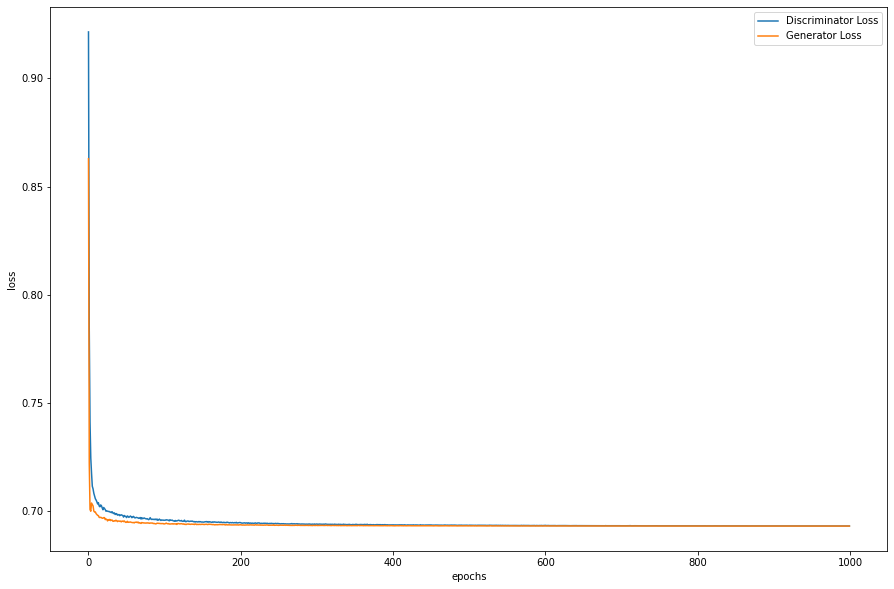

In [176]:

generator_diab, discriminator_diab, gen_loss_diab, disc_loss_diab = train_gan(diab_x, epochs=1000, dataset_type='diab')


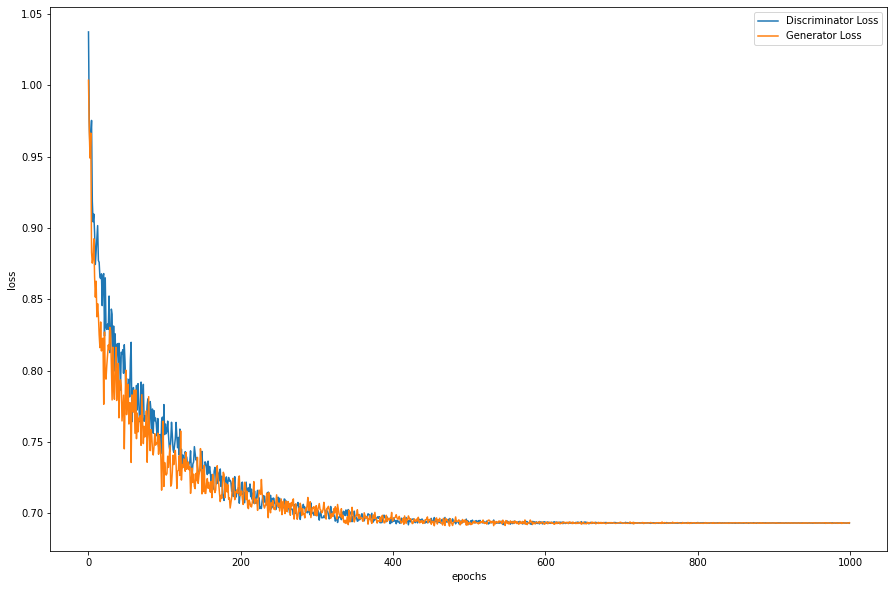

In [177]:
generator_cred, discriminator_cred, gen_loss_cred, disc_loss_cred  = train_gan(cred_x, epochs=1000, dataset_type='cred')
visualize_perf(disc_loss_cred, gen_loss_cred)

## Analyzing model

### Samples that are fooling The Discrimnator

In [182]:
def generate_samples(generator, discriminator, num_samples, noise_dim=5):
    noise = tf.random.normal([num_samples, noise_dim])
    generated_samples = generator(noise, training=False)
    disc_pred = discriminator(generated_samples, training=False)
    
    return generated_samples, disc_pred


In [252]:
def get_samples(num_fools, generator, discriminator, noise_dim=5, fool=True):
    generated_samples, disc_pred = generate_samples(generator, discriminator, num_fools * 5, noise_dim=5)
    disc_pred, generated_samples = disc_pred.numpy(), generated_samples.numpy()
    
    if fool:
        cond = disc_pred >= 0.5
        disc_pred_filtered = disc_pred[cond]
        samples_idx = np.argsort(disc_pred_filtered)[-num_fools:]
    else:
        cond = disc_pred < 0.5
        disc_pred_filtered = disc_pred[cond]
        samples_idx = np.argsort(disc_pred_filtered)[:num_fools]
    
    return disc_pred_filtered[samples_idx], generated_samples[(cond).reshape(-1), :][samples_idx, :]
    

**Diabities Dataset**

In [253]:
fooled = get_samples(10, generator_diab, discriminator_diab, noise_dim=5, fool=True)
fooled

(array([0.50081915, 0.5016472 , 0.50271153, 0.5043738 , 0.50642544,
        0.5085728 , 0.5088412 , 0.51507396, 0.5198866 , 0.5215295 ],
       dtype=float32),
 array([[0.44621328, 0.4656572 , 0.54435146, 0.4755549 , 0.57730097,
         0.49612862, 0.4914133 , 0.5477364 ],
        [0.43289554, 0.46111694, 0.57651144, 0.45005092, 0.6339835 ,
         0.48252937, 0.46633834, 0.5794439 ],
        [0.43128523, 0.46169457, 0.57048076, 0.4528043 , 0.6241297 ,
         0.4859084 , 0.46977317, 0.5769618 ],
        [0.4169547 , 0.4523097 , 0.59803534, 0.44097197, 0.6601335 ,
         0.47460106, 0.4592777 , 0.59422904],
        [0.4376355 , 0.4662777 , 0.54661965, 0.52535295, 0.52129424,
         0.5314284 , 0.48804435, 0.51223797],
        [0.41270408, 0.45377436, 0.5868574 , 0.44893712, 0.6459993 ,
         0.47788358, 0.46895033, 0.5841317 ],
        [0.43510213, 0.46891195, 0.54865795, 0.51421636, 0.53874   ,
         0.52446735, 0.48228064, 0.5153803 ],
        [0.4354357 , 0.46105424, 0.

**German Credit Dataset**

In [260]:
fooled = get_samples(10, generator_cred, discriminator_cred, noise_dim=5, fool=True)
fooled

(array([], dtype=float32), array([], shape=(0, 61), dtype=float32))

### Samples that failed to fool the Discriminator

**Diabities Dataset**

In [254]:
not_fooled = get_samples(10, generator_diab, discriminator_diab, noise_dim=5, fool=False)
not_fooled

(array([0.45707068, 0.46031544, 0.46133786, 0.4614335 , 0.4647732 ,
        0.4649205 , 0.46523875, 0.46715125, 0.4675282 , 0.46958825],
       dtype=float32),
 array([[0.50940347, 0.489824  , 0.49020544, 0.4650087 , 0.5558457 ,
         0.49985096, 0.4977008 , 0.5290052 ],
        [0.50068367, 0.48310444, 0.5052644 , 0.4773531 , 0.5530787 ,
         0.5047113 , 0.49398744, 0.5222824 ],
        [0.495118  , 0.48049816, 0.5178602 , 0.46853435, 0.5311509 ,
         0.5153886 , 0.49949184, 0.53788483],
        [0.50771767, 0.4908179 , 0.4979594 , 0.47796026, 0.5212395 ,
         0.5190447 , 0.50098854, 0.5191735 ],
        [0.48594624, 0.48133752, 0.5157862 , 0.46663636, 0.5641771 ,
         0.50017947, 0.4901434 , 0.5401271 ],
        [0.4968089 , 0.488613  , 0.5036657 , 0.4921671 , 0.5188291 ,
         0.52179307, 0.49508795, 0.5104606 ],
        [0.5011831 , 0.47634226, 0.52466124, 0.47814965, 0.5021194 ,
         0.51633865, 0.52072716, 0.5385153 ],
        [0.5185289 , 0.49072397, 0.

**German Credit Dataset**

In [261]:
not_fooled = get_samples(10, generator_cred, discriminator_cred, noise_dim=5, fool=False)
not_fooled

(array([0.49917036, 0.4991981 , 0.49921814, 0.4992583 , 0.49927434,
        0.4992903 , 0.49931577, 0.49933177, 0.49939626, 0.49944213],
       dtype=float32),
 array([[0.45496154, 0.4297197 , 0.47199243, 0.5519392 , 0.41288576,
         0.47820112, 0.41761944, 0.47719538, 0.542077  , 0.51327515,
         0.52348423, 0.55221003, 0.5083032 , 0.51212204, 0.4135546 ,
         0.5639792 , 0.5608447 , 0.49041095, 0.45941785, 0.50621885,
         0.534629  , 0.4788121 , 0.57687163, 0.59531665, 0.47793624,
         0.55754423, 0.49641162, 0.45352918, 0.42173535, 0.51965594,
         0.57930815, 0.62750787, 0.5293608 , 0.4366476 , 0.4647319 ,
         0.55934715, 0.56623536, 0.5138317 , 0.50253284, 0.47470537,
         0.5045482 , 0.41152346, 0.41494313, 0.47050726, 0.49751174,
         0.5364484 , 0.5316484 , 0.54589206, 0.5500335 , 0.4685614 ,
         0.54094285, 0.5080359 , 0.5013391 , 0.48558456, 0.5706198 ,
         0.42840353, 0.41446888, 0.5630552 , 0.48573717, 0.479638  ,
         0.5

### 100 Random Samples

###  Loss Graphs